<a href="https://colab.research.google.com/github/Abhishek-003/CreditCard-Default-Prediction/blob/main/CreditCard_Default_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install fancyimpute

     |████████████████████████████████| 154 kB 26.8 MB/s 
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29899 sha256=e0065e8bfa2043fd4bafea28d9424a0dee7b6bbb93f2ea13e62bc45b386c2c6a
  Stored in directory: /root/.cache/pip/wheels/e3/04/06/a1a7d89ef4e631ce6268ea2d8cde04f7290651c1ff1025ce68
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11353 sha256=bd07540820b71bd9387c0fdc6c346c86cda04001b98a3540093db6de46755c34
  Stored in directory: /root/.cache/pip/wheels/72/21/a8/a045cacd9838abd5643f6bfa852c0796a99d6b1494760494e0
Successfully built fancyimpute knnimpute


## Importing necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Loading Datasets and preprocessing

In [5]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [6]:
train_data.head()

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
0,CST_115179,ita Bose,46,F,N,Y,0.0,107934.04,612.0,Unknown,1.0,1.0,33070.28,18690.93,73,544.0,2,1,1
1,CST_121920,Alper Jonathan,29,M,N,Y,0.0,109862.62,2771.0,Laborers,2.0,0.0,15329.53,37745.19,52,857.0,0,0,0
2,CST_109330,Umesh Desai,37,M,N,Y,0.0,230153.17,204.0,Laborers,2.0,0.0,48416.60,41598.36,43,650.0,0,0,0
3,CST_128288,Rie,39,F,N,Y,0.0,122325.82,11941.0,Core staff,2.0,0.0,22574.36,32627.76,20,754.0,0,0,0
4,CST_151355,McCool,46,M,Y,Y,0.0,387286.00,1459.0,Core staff,1.0,0.0,38282.95,52950.64,75,927.0,0,0,0


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45528 entries, 0 to 45527
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              45528 non-null  object 
 1   name                     45528 non-null  object 
 2   age                      45528 non-null  int64  
 3   gender                   45528 non-null  object 
 4   owns_car                 44981 non-null  object 
 5   owns_house               45528 non-null  object 
 6   no_of_children           44754 non-null  float64
 7   net_yearly_income        45528 non-null  float64
 8   no_of_days_employed      45065 non-null  float64
 9   occupation_type          45528 non-null  object 
 10  total_family_members     45445 non-null  float64
 11  migrant_worker           45441 non-null  float64
 12  yearly_debt_payments     45433 non-null  float64
 13  credit_limit             45528 non-null  float64
 14  credit_limit_used(%)  

**Observation :** 

*  There are 13 numerical columns(Some of them are actually categorical).
*  There are 6 categorical columns.

In [8]:
# Dropping the name and customer_id columns, since they cannot help  us Predict 
# the credit card default

train_data.drop(['name', 'customer_id'], axis=1, inplace=True)

### Performing Exploratory Data Analysis

In [9]:
total_defaults = (len(train_data.loc[train_data['credit_card_default']==1])/len(train_data))*100
total_non_defaults = (len(train_data.loc[train_data['credit_card_default']==0])/len(train_data))*100
print(f'There are {round(total_defaults,2)} defalts')
print(f'There are {round(total_non_defaults,2)} non_defalts')

There are 8.12 defalts
There are 91.88 non_defalts


There is a class imbalance in the dataset. The number of non-defaults is greater than the total defaults. Maybe since there is no recession almost 91% were able to pay there credit card bill on time.

### Checking for missing values

In [10]:
missing_val = train_data.isnull().sum()/len(train_data)
missing_val = missing_val[missing_val > 0]*100
missing_val.sort_values(inplace=True)
print('Columns with percentages of missing values')
missing_val

Columns with percentages of missing values


credit_score            0.017572
total_family_members    0.182305
migrant_worker          0.191091
yearly_debt_payments    0.208663
no_of_days_employed     1.016957
owns_car                1.201458
no_of_children          1.700053
dtype: float64

In [11]:
missing_val = missing_val.to_frame()
missing_val.columns = ['count']
missing_val.index.names = ['Name']
missing_val['Name'] = missing_val.index
missing_val

,count,Name
Name,,
credit_score,0.017572,credit_score
total_family_members,0.182305,total_family_members
migrant_worker,0.191091,migrant_worker
yearly_debt_payments,0.208663,yearly_debt_payments
no_of_days_employed,1.016957,no_of_days_employed
owns_car,1.201458,owns_car
no_of_children,1.700053,no_of_children


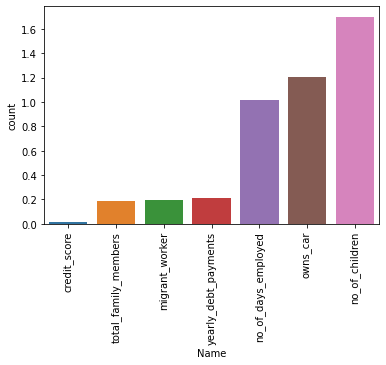

In [12]:
_ = sns.barplot(x = 'Name', y = 'count', data=missing_val)
plt.xticks(rotation = 90)
plt.show()

### Performing Exploratory Data Analysis

In [13]:
train_data.describe()

,age,no_of_children,net_yearly_income,no_of_days_employed,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
count,45528.000000,44754.000000,4.552800e+04,45065.000000,45445.000000,45441.000000,45433.000000,4.552800e+04,45528.00000,45520.000000,45528.000000,45528.000000,45528.000000
mean,38.993411,0.420655,2.006556e+05,67609.289293,2.158081,0.179111,31796.965311,4.354842e+04,52.23502,782.791257,0.060710,0.050540,0.081203
std,9.543990,0.724097,6.690740e+05,139323.524434,0.911572,0.383450,17269.727234,1.487847e+05,29.37691,100.619746,0.264629,0.219059,0.273149
min,23.000000,0.000000,2.717061e+04,2.000000,1.000000,0.000000,2237.470000,4.003140e+03,0.00000,500.000000,0.000000,0.000000,0.000000
25%,31.000000,0.000000,1.263458e+05,936.000000,2.000000,0.000000,19231.140000,2.397381e+04,27.00000,704.000000,0.000000,0.000000,0.000000
50%,39.000000,0.000000,1.717149e+05,2224.000000,2.000000,0.000000,29081.650000,3.568804e+04,54.00000,786.000000,0.000000,0.000000,0.000000
75%,47.000000,1.000000,2.406038e+05,5817.000000,3.000000,0.000000,40561.150000,5.343576e+04,78.00000,867.000000,0.000000,0.000000,0.000000
max,55.000000,9.000000,1.407590e+08,365252.000000,10.000000,1.000000,328112.860000,3.112997e+07,99.00000,949.000000,2.000000,1.000000,1.000000


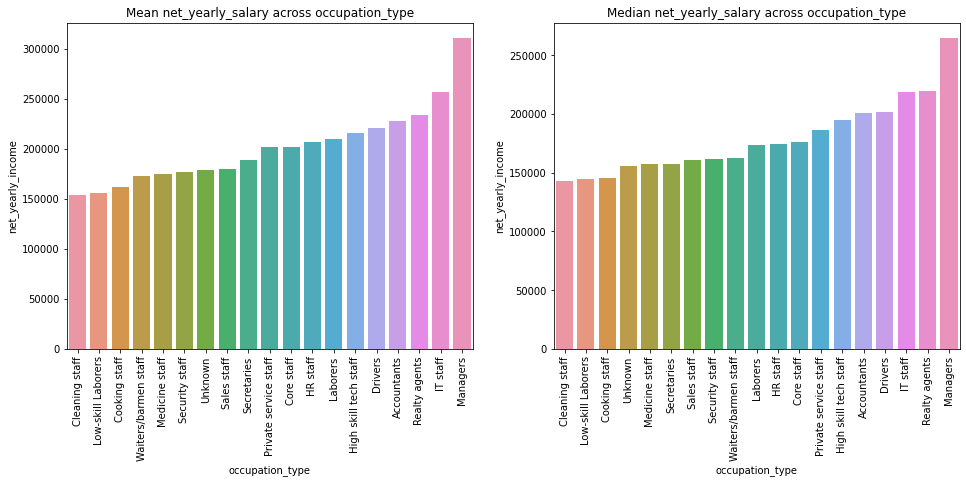

In [14]:
# Checking if there is any relationship between net_yearly_income and occupation_type
req = train_data.groupby('occupation_type', as_index=False)['net_yearly_income'].mean()
req.sort_values('net_yearly_income', inplace=True)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
_ = sns.barplot(x='occupation_type', y='net_yearly_income', data=req)
_ = plt.xticks(rotation = 90)
_ = plt.title('Mean net_yearly_salary across occupation_type')

req2 = train_data.groupby('occupation_type', as_index=False)['net_yearly_income'].median()
req2.sort_values('net_yearly_income', inplace=True)
plt.subplot(1,2,2)
_ = sns.barplot(x='occupation_type', y='net_yearly_income', data=req2)
_ = plt.xticks(rotation = 90)
_ = plt.title('Median net_yearly_salary across occupation_type')


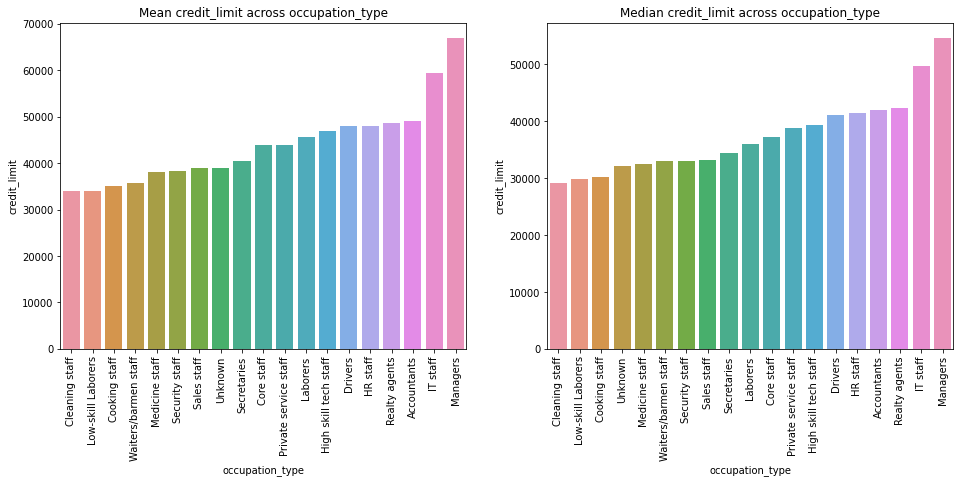

In [15]:
# Checking if there is any relationship between credit_limit and occupation_type
req = train_data.groupby('occupation_type', as_index=False)['credit_limit'].mean()
req.sort_values('credit_limit', inplace=True)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
_ = sns.barplot(x='occupation_type', y='credit_limit', data=req)
_ = plt.xticks(rotation = 90)
_ = plt.title('Mean credit_limit across occupation_type')

req2 = train_data.groupby('occupation_type', as_index=False)['credit_limit'].median()
req2.sort_values('credit_limit', inplace=True)
plt.subplot(1,2,2)
_ = sns.barplot(x='occupation_type', y='credit_limit', data=req2)
_ = plt.xticks(rotation = 90)
_ = plt.title('Median credit_limit across occupation_type')


**Observation :** It looks like persons with high net_yearly_income tends to have higher credit limit.

In [ ]:
d = ['no_of_children','net_yearly_income','no_of_days_employed','total_family_members',
    'yearly_debt_payments','credit_limit','credit_limit_used(%)','credit_score']


In [ ]:
def create_scatter(x, y, fig, data):
    plt.subplot(10,3,fig)
    plt.scatter(data[x],data[y])
    plt.title(x+' vs '+y)
    plt.ylabel(y)
    plt.xlabel(x)

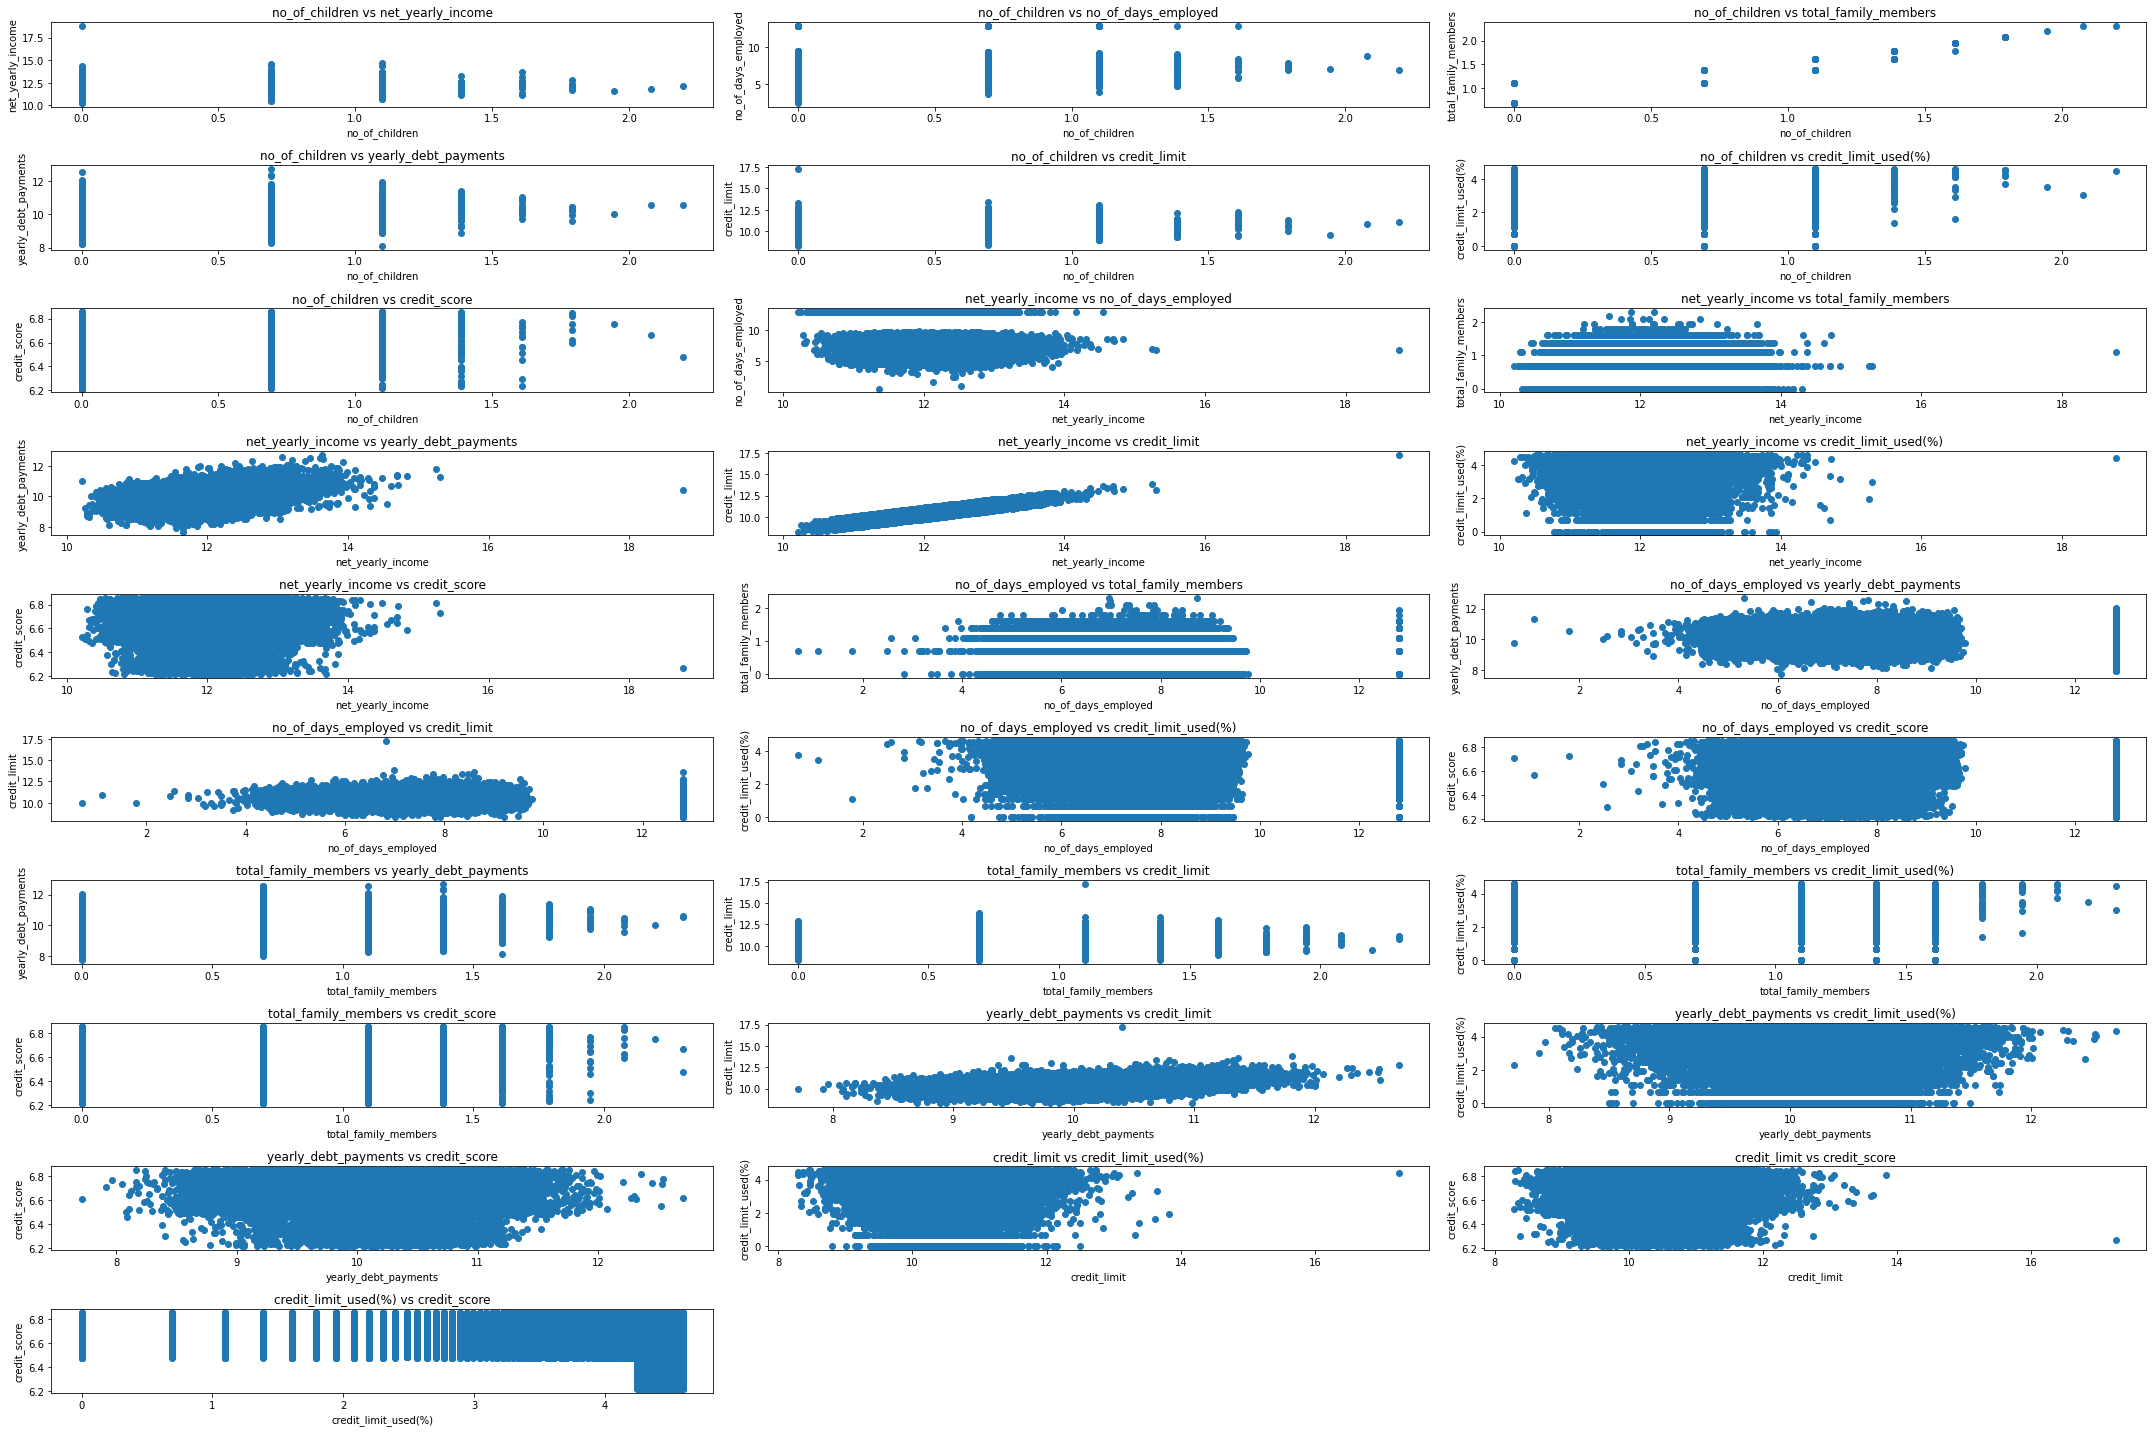

In [ ]:
# Plotting almost every numerical feature with net_yearly_income, to observe if there is any trend 
x = train_data[d].apply(np.log)
plt.figure(figsize=(30,20))
count = 1
for i in range(len(d)):
    for j in range(i+1, len(d)):
        create_scatter(d[i], d[j], count, x)
        count += 1
plt.tight_layout()

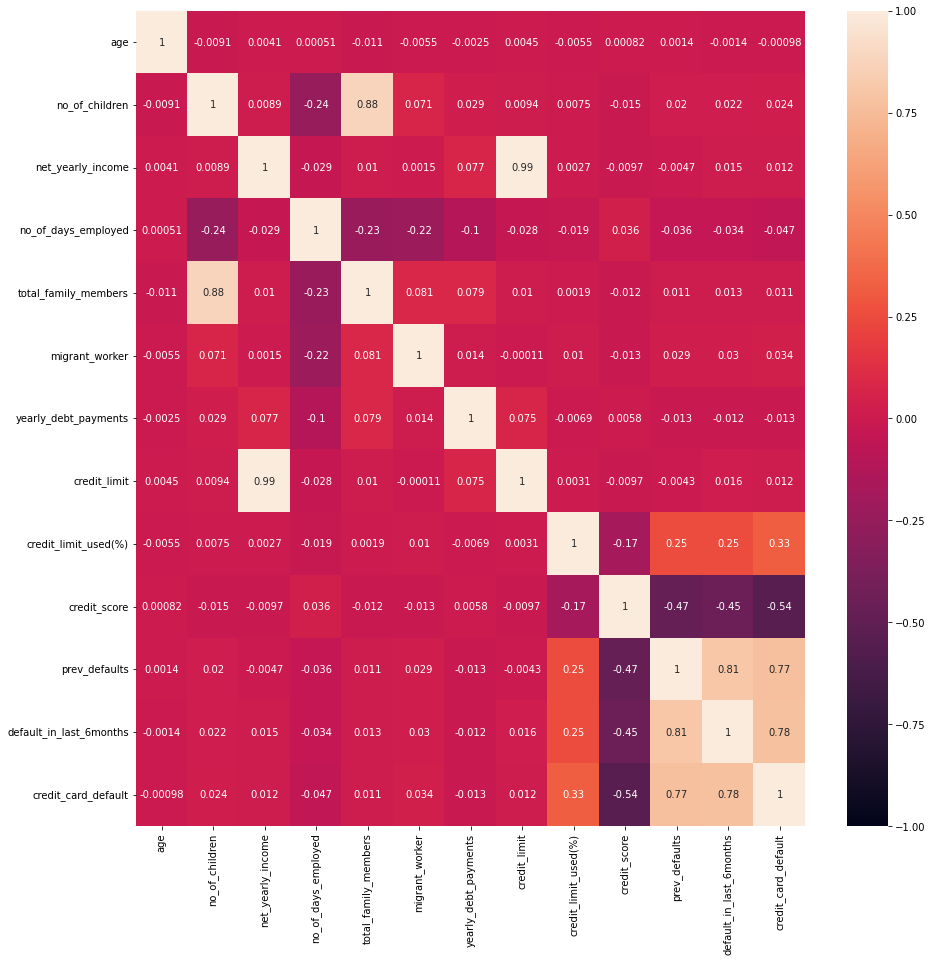

In [ ]:
## Visualizing correlation heatmap

corr = train_data.corr()
plt.figure(figsize=(15, 15))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
plt.show()

## Imputing missing values

### Imputing categorical variabes using KNN imputer

In [ ]:
numerical_columns = ['no_of_children','net_yearly_income','no_of_days_employed','total_family_members',
    'yearly_debt_payments','credit_limit','credit_limit_used(%)','credit_score', 'prev_defaults']

dupli_data1 = train_data.copy(deep=True).drop('credit_card_default', axis=1)
dupli_data2 = test_data.copy(deep=True).drop(['customer_id', 'name'], axis=1)
dupli_data = pd.concat([dupli_data1, dupli_data2])

In [ ]:
dupli_data.isnull().sum(

age                          0
gender                       0
owns_car                   679
owns_house                   0
no_of_children             964
net_yearly_income            0
no_of_days_employed        568
occupation_type              0
total_family_members       114
migrant_worker             113
yearly_debt_payments       117
credit_limit                 0
credit_limit_used(%)         0
credit_score                11
prev_defaults                0
default_in_last_6months      0
dtype: int64

In [ ]:
null_data = train_data[train_data.isnull().any(axis=1)]

In [ ]:
null_data

,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
8,40,F,NaN,Y,0.0,210091.43,11551.0,Laborers,2.0,0.0,21521.89,65037.74,14,783.0,0,0,0
21,36,F,N,Y,NaN,253922.42,433.0,Unknown,2.0,0.0,51044.13,60924.47,19,651.0,0,0,0
40,47,F,NaN,Y,0.0,229370.35,352.0,Sales staff,2.0,0.0,35347.36,27213.73,87,733.0,0,0,0
114,51,F,N,Y,0.0,128675.13,2855.0,Unknown,2.0,NaN,12097.89,25834.20,76,890.0,0,0,0
119,45,M,NaN,Y,0.0,213866.59,2272.0,Core staff,2.0,0.0,22836.78,71050.18,21,802.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45336,26,F,N,Y,NaN,220105.96,3979.0,Sales staff,NaN,0.0,26035.06,75625.81,40,892.0,0,0,0
45355,23,M,Y,Y,0.0,232431.74,365248.0,Unknown,2.0,0.0,NaN,42315.63,41,746.0,0,0,0
45371,54,F,Y,Y,2.0,82964.66,NaN,Cleaning staff,4.0,1.0,39510.18,27861.75,4,947.0,0,0,0
45381,34,F,N,N,NaN,142275.80,1365.0,Sales staff,3.0,1.0,43073.65,41267.76,30,696.0,0,0,0
